# Sanity check of ARPACK MAC results

## Check 1: Comparison with known QCFFPI results

In [1]:
%matplotlib widget

from os import path
import numpy as np
import matplotlib.pyplot as plt
from qcnico.coords_io import read_xsf
from remove_dangling_carbons import remove_dangling_carbons


datadir = path.expanduser("~/Desktop/simulation_outputs/percolation/40x40")
posdir = path.join(datadir, "structures")

lbls = [f'bigMAC-{n}' for n in [2,3,5,6,7,9,10]]

rCC_MAC = 1.8

def getARPACKdata(datadir,lbls):
    edir = path.join(datadir,'eARPACK')
    Mdir = path.join(datadir,'MOs_ARPACK')
    ee = [np.load(path.join(edir,f'eARPACK_{lbl}.npy')) for lbl in lbls]
    MM = [np.load(path.join(Mdir,f'MOs_ARPACK_{lbl}.npy')) for lbl in lbls]
    return ee, MM

def get_pos(posdir,lbls):
    return [remove_dangling_carbons(read_xsf(path.join(posdir,f"{lbl}_relaxed.xsf"))[0],rCC_MAC) for lbl in lbls]
    


ee, MM = getARPACKdata(datadir,lbls)
posarrs = get_pos(posdir,lbls)

## Check 2: General appearance and localisation properties of ARPACK MOs on large graphene ribbons

## Check 3: General appearance and localisation properties of ARPACK MOs on large graphene ribbons

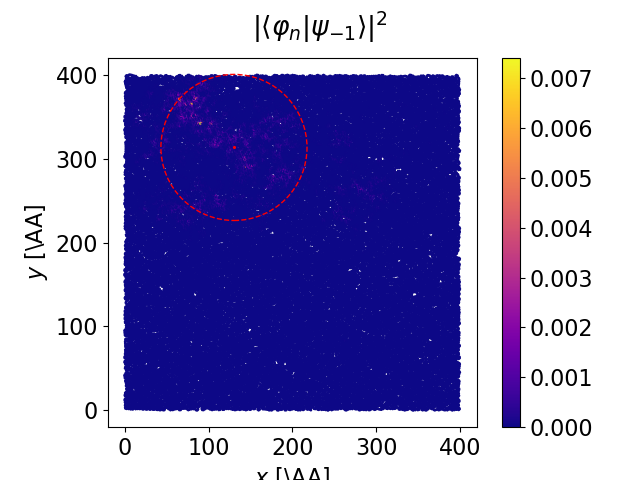

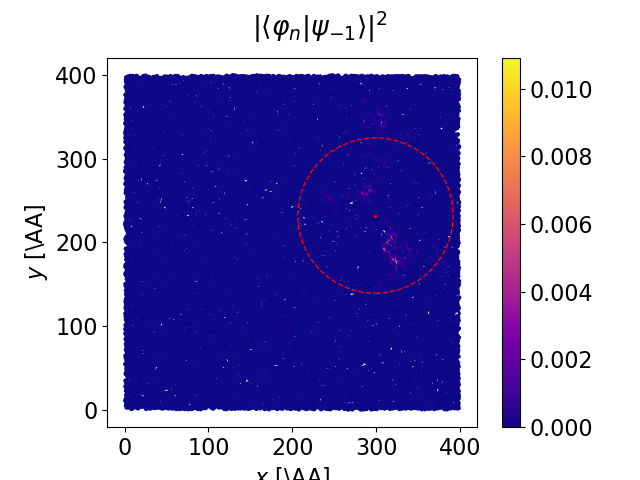

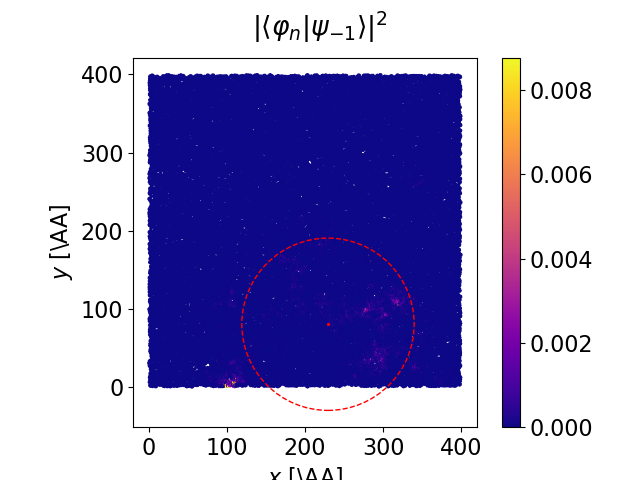

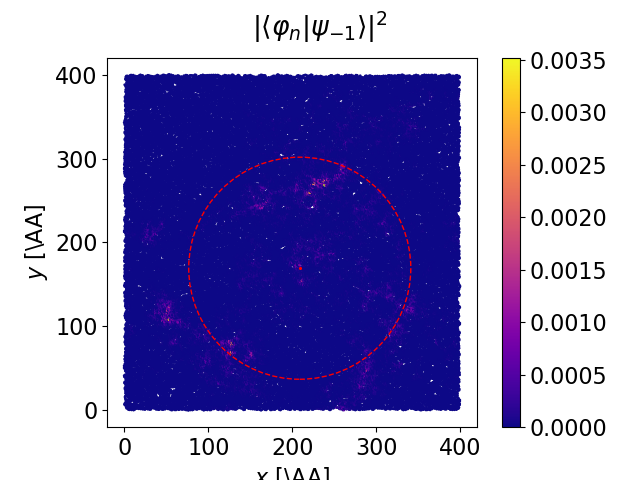

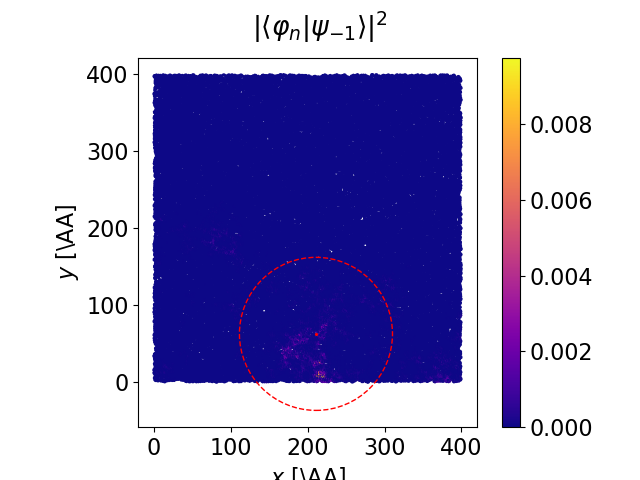

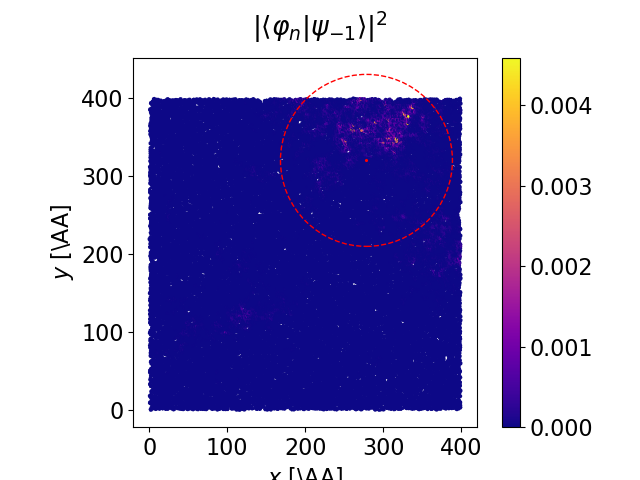

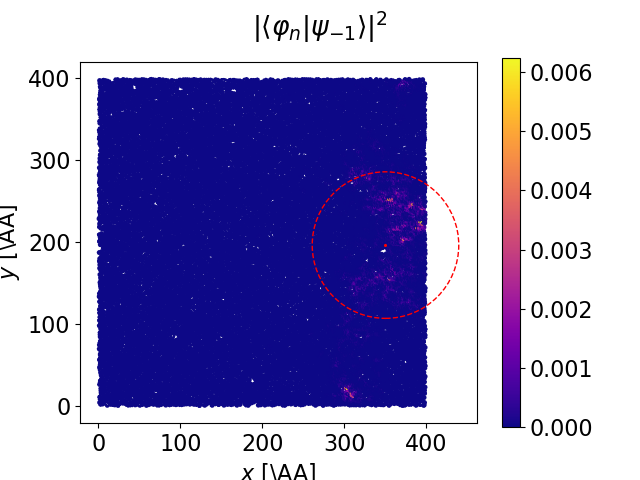

In [2]:
from qcnico.qcplots import plot_MO

for pos, M in zip(posarrs,MM):
    plot_MO(pos,M,-1,dotsize=1.0,show_COM=True,show_rgyr=True,show=True,usetex=False)


True
True
True
True
True
True
True


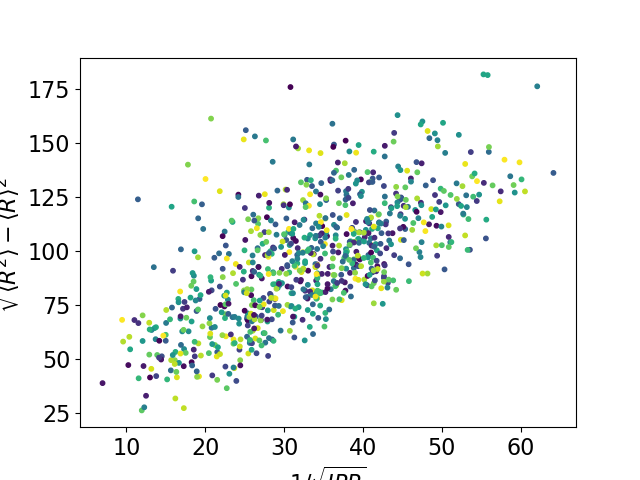

In [3]:

from qcnico.qchemMAC import inverse_participation_ratios, MO_rgyr, all_rgyrs
from qcnico.qcplots import plot_loc_discrep

fig, ax = plt.subplots()

for e, M, pos in zip(ee, MM, posarrs):
    e -= e[0]
    iprs = inverse_participation_ratios(M)
    rgyrs = MO_rgyr(pos,M)
    rgyrs2 = all_rgyrs(pos,M)
    print(np.all(rgyrs == rgyrs2))
    plot_loc_discrep(iprs, rgyrs, e, usetex=False, show=False,plt_objs=(fig,ax),show_cbar=False)
plt.show()


In [4]:
from qcnico.qcplots import plot_loc_discrep
